In [2]:
import glob
import itertools
import numpy as np 
import pandas as pd
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer


/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_91242/3528264843.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
name = "syn5_final"
file = f"/Users/melloo21/Desktop/NUS Items/CS4220/cs4220_projects/data/raw_csv/{name}.csv"

In [18]:
# read_file and check type
df = pd.read_csv(file,sep='\t')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46915 entries, 0 to 46914
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        46915 non-null  int64  
 1   Chr               46915 non-null  object 
 2   START_POS_REF     46915 non-null  int64  
 3   END_POS_REF       46915 non-null  int64  
 4   REF               46626 non-null  object 
 5   ALT               46626 non-null  object 
 6   REF_MFVdVs        46626 non-null  object 
 7   ALT_MFVdVs        46626 non-null  object 
 8   Sample_Name       46626 non-null  object 
 9   FILTER_Mutect2    46626 non-null  object 
 10  FILTER_Freebayes  46626 non-null  object 
 11  FILTER_Vardict    46626 non-null  object 
 12  FILTER_Varscan    46626 non-null  object 
 13  m2_MQ             45933 non-null  float64
 14  m2_FS             45933 non-null  float64
 15  m2_MQ0            45933 non-null  float64
 16  m2_MQRankSum      45932 non-null  float6

/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_91242/2241031030.py:2: DtypeWarning: Columns (1,23,24,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file,sep='\t')


None

[Text(0, 0, '3.88149'), Text(0, 0, '96.1185')]

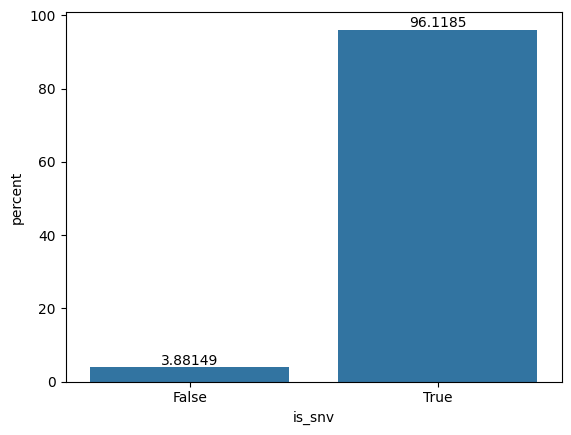

In [19]:
# Check for the proportion of SNV and non SNV
ax = sns.countplot(df, x="is_snv", stat="percent")
ax.bar_label(ax.containers[0])

# Missing Data Exploration

#### The entirely missing column includes  
1. m2_PON              1.000000 -- Description="Count from Panel of Normals">
2. f_MIN_DP            1.000000 -- Description="Total read depth at the locus">
3. vd_SAMPLE           0.999878 -- Description="Sample name (with whitespace translated to underscores)">

In [1]:
# Check for null values
sorted_list_of_null = (df.isnull().sum()/len(df)).sort_values(ascending=False)
display(sorted_list_of_null)
print(f" The dataset shape and size are :: {df.shape}")
msno.bar(df)

NameError: name 'df' is not defined

### 1. Missing Completely at Random (MCAR)

The missing values on a given variable (Y) are not associated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.

### 2. Missing at Random (MAR)

MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.

### 3. Missing Not at Random (MNAR)

Missingness depends on unobserved data or the value of the missing data itself.



<Axes: >

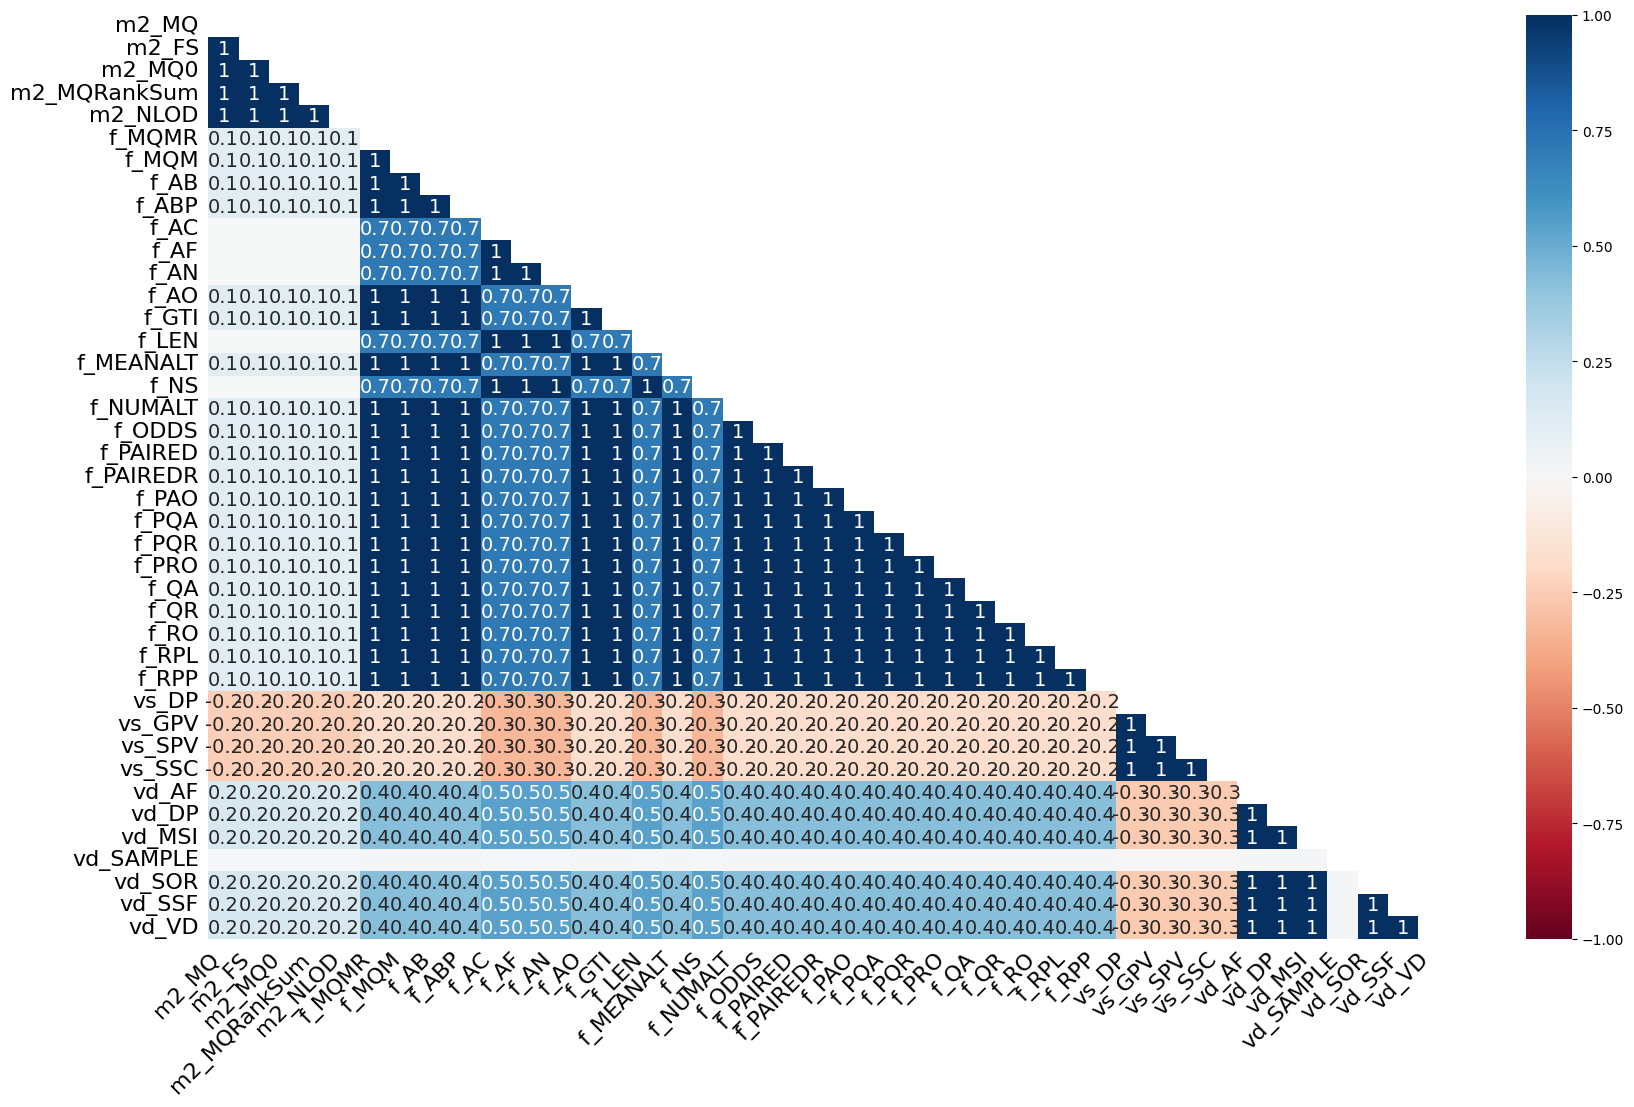

In [38]:
# The heatmap shows that for the algo if it is missing, there is a very high chance 
# That the other parameters use to predict will be missing as well
msno.heatmap(df)

<Axes: >

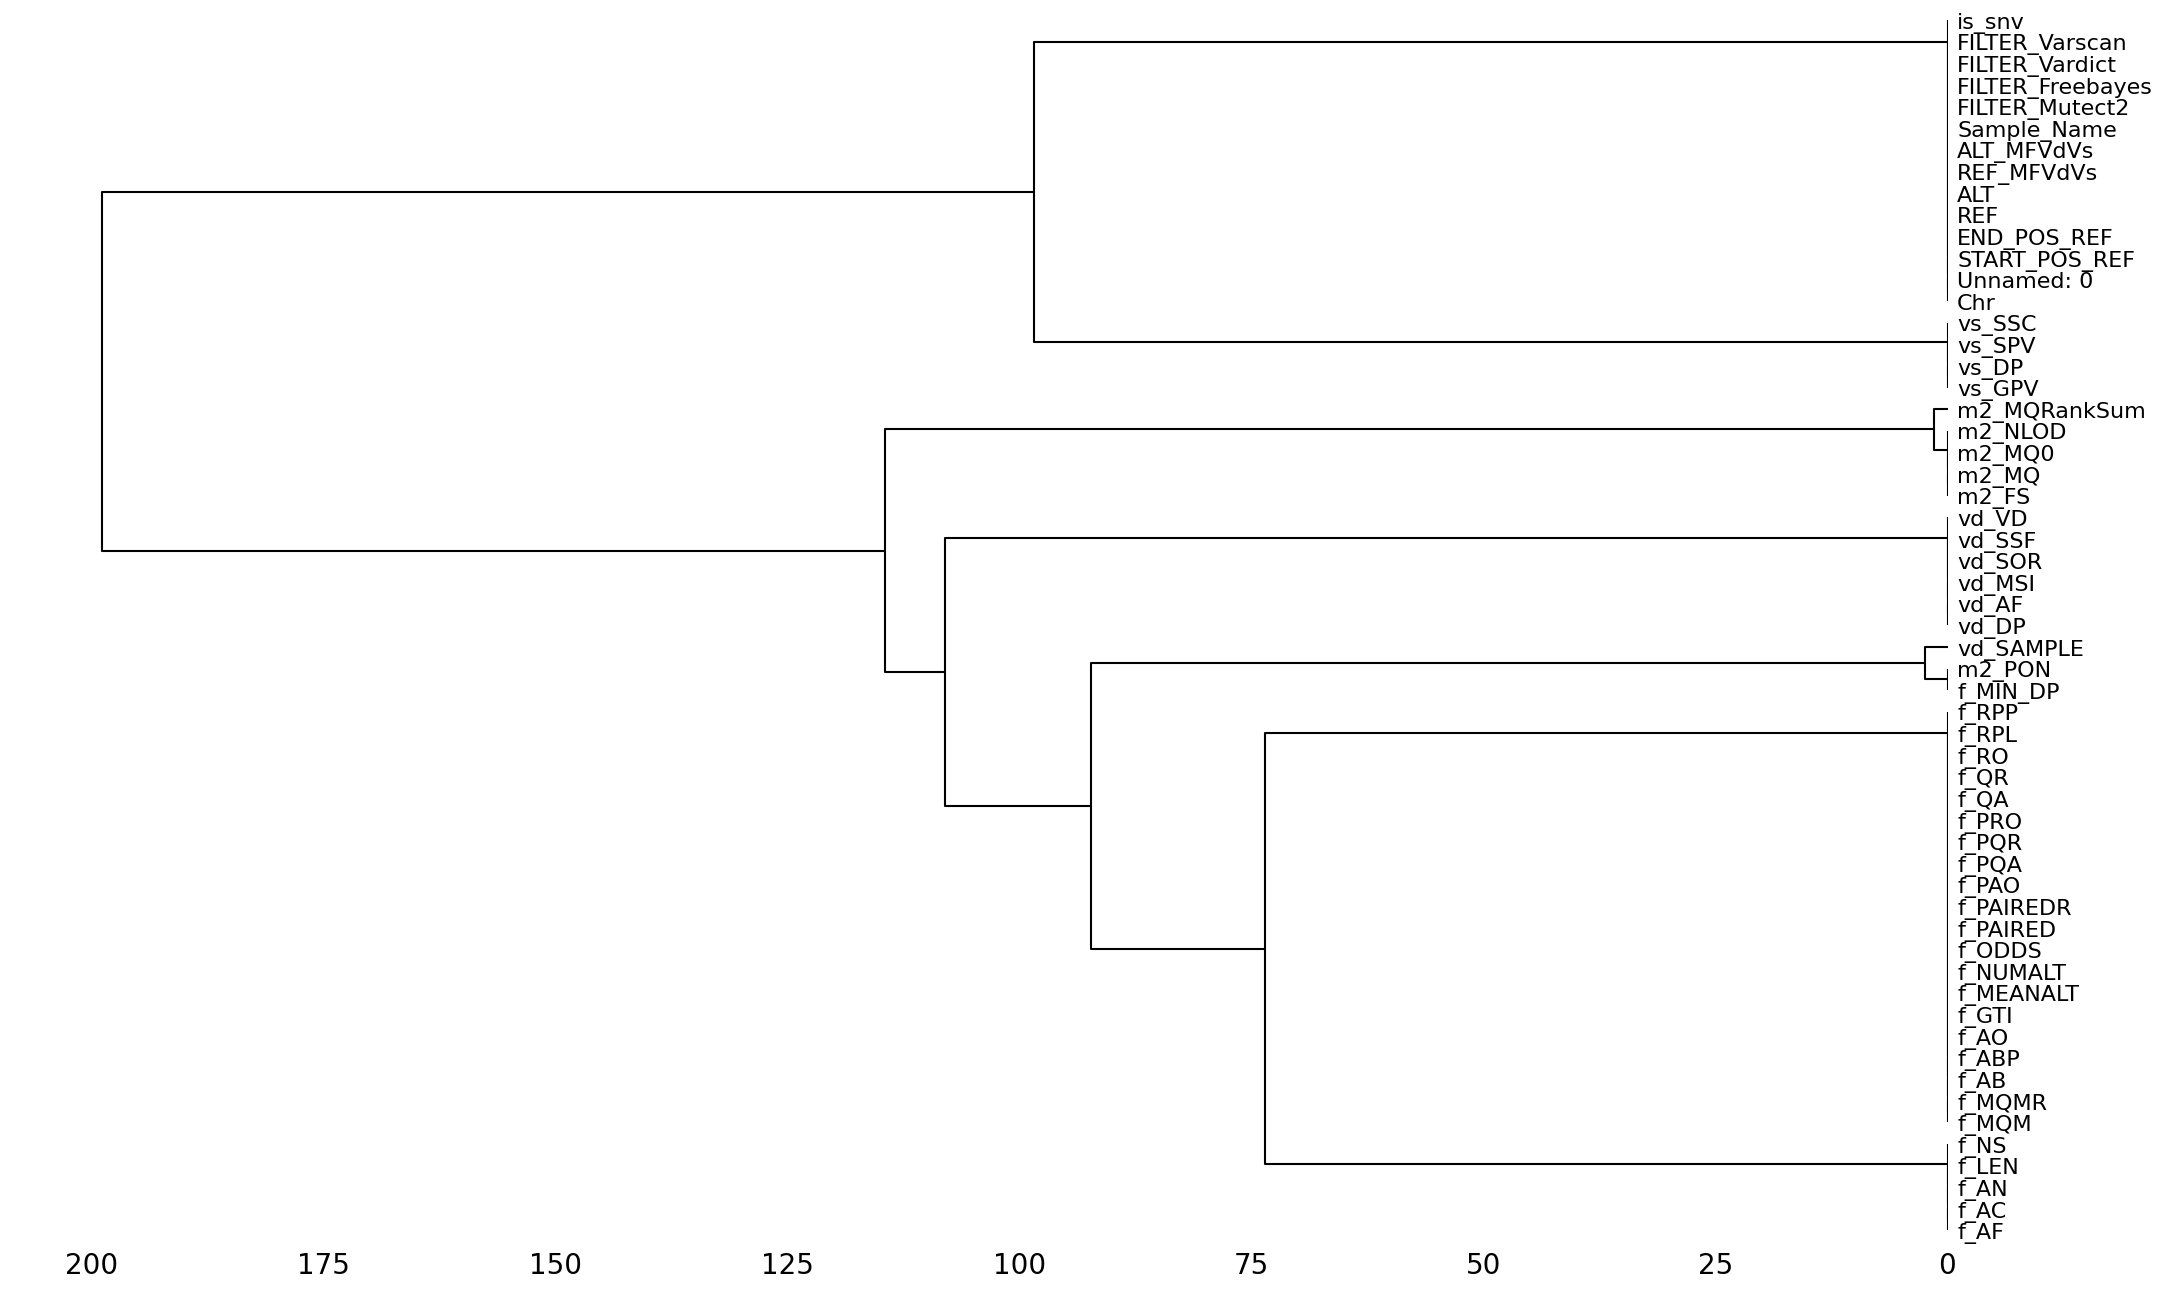

In [37]:
msno.dendrogram(df)

### Data imputation
1. Imputing with a constant
2. Imputing by statistic -- Mean, Median , Mode
3. KNN Based
4. MICE Based
 
fyi :: Difficulty in doing outlier detection as well due to presence of high amount of missing data

In [61]:
# Change into features and labels 
# Dropping entirely null columns
x_df = df.copy().drop(columns=["is_snv","m2_PON","f_MIN_DP"])
y_df = df.copy()[["is_snv"]]

In [63]:
# Split data into categorical and non categorical
list_of_categorical = list()
list_of_numerical = list()

numerical = ["int64", "float64"]
for elem in x_df.dtypes.items():
    name, col_type = elem
    if col_type in numerical:
        print(f" numeric {col_type} :: {name}")
        list_of_numerical.append(name)
    else:
        print(f" cat {col_type} :: {name}")
        list_of_categorical.append(name)


 numeric int64 :: Unnamed: 0
 cat object :: Chr
 numeric int64 :: START_POS_REF
 numeric int64 :: END_POS_REF
 cat object :: REF
 cat object :: ALT
 cat object :: REF_MFVdVs
 cat object :: ALT_MFVdVs
 cat object :: Sample_Name
 cat bool :: FILTER_Mutect2
 cat bool :: FILTER_Freebayes
 cat bool :: FILTER_Vardict
 cat bool :: FILTER_Varscan
 numeric float64 :: m2_MQ
 numeric float64 :: m2_FS
 numeric float64 :: m2_MQ0
 numeric float64 :: m2_MQRankSum
 numeric float64 :: m2_NLOD
 numeric float64 :: f_MQMR
 numeric float64 :: f_MQM
 numeric float64 :: f_AB
 numeric float64 :: f_ABP
 numeric float64 :: f_AC
 numeric float64 :: f_AF
 numeric float64 :: f_AN
 numeric float64 :: f_AO
 numeric float64 :: f_GTI
 numeric float64 :: f_LEN
 numeric float64 :: f_MEANALT
 numeric float64 :: f_NS
 numeric float64 :: f_NUMALT
 numeric float64 :: f_ODDS
 numeric float64 :: f_PAIRED
 numeric float64 :: f_PAIREDR
 numeric float64 :: f_PAO
 numeric float64 :: f_PQA
 numeric float64 :: f_PQR
 numeric float6

In [131]:
# x_df[list_of_categorical].info()
x_df[list_of_categorical].describe()

,Chr,REF,ALT,REF_MFVdVs,ALT_MFVdVs,Sample_Name,FILTER_Mutect2,FILTER_Freebayes,FILTER_Vardict,FILTER_Varscan,vd_SAMPLE
count,49365,49365,49365,49365,49365,49365,49365,49365,49365,49365,6
unique,74,4,4,60,590,1,2,2,2,2,1
top,1,C,T,NA/NA/NA/T/,NA/NA/NA/G/,icgc_cll-T,False,False,False,True,icgc_cll-T
freq,3663,12690,13256,7068,6858,49365,43855,42945,42125,34769,6


In [84]:
# Basic check of which rows have inf values
numerical_df = x_df[list_of_numerical].copy()
m = (numerical_df == np.inf)
inf_check = numerical_df.loc[m.any(axis=1), m.any(axis=0)]
display(inf_check) # Description="Odds ratio">
# Replace inf value with nan to prevent numerical overflow for imputation methods
# df.replace(np.inf, np.nan)

# OR=1 Exposure does not affect odds of outcome
# OR>1 Exposure associated with higher odds of outcome
# OR<1 Exposure associated with lower odds of outcome

# Should I replace inf with a high value?
numerical_df = numerical_df.replace(np.inf, 100)

,vd_SOR
8,inf
11,inf
18,inf
19,inf
21,inf
...,...
49207,inf
49209,inf
49210,inf
49211,inf


### Mean imputation

In [86]:
numerical_mean_imp = numerical_df.copy()
# Impute with numerical columns mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Replacing the values
numerical_mean_imp.iloc[:,:] = imp.fit_transform(numerical_mean_imp)

### Median imputation

In [87]:
numerical_median_imp = numerical_df.copy()
# Impute with numerical columns mean
imp = SimpleImputer(missing_values=np.nan, strategy='median')
# Replacing the values
numerical_median_imp.iloc[:,:] = imp.fit_transform(numerical_median_imp)

### Mode imputation

In [89]:
numerical_mode_imp = numerical_df.copy()
# Impute with numerical columns mean
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# Replacing the values
numerical_mode_imp.iloc[:,:] = imp.fit_transform(numerical_mode_imp)

### K Means imputation

In [93]:
numerical_kmeans_imp = numerical_df.copy()
imp = KNNImputer(n_neighbors= 3)
numerical_kmeans_imp.iloc[:,:] = imp.fit_transform(numerical_kmeans_imp)

KeyboardInterrupt: 

# EDA of Features

[Text(0, 0, '97.3281'), Text(0, 0, '2.67193')]

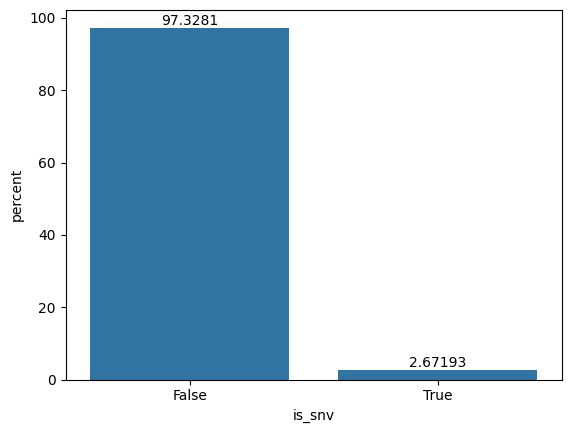

In [28]:
# Check for the proportion of SNV and non SNV
ax = sns.countplot(df, x="is_snv", stat="percent")
ax.bar_label(ax.containers[0])

In [99]:
df.columns

Index(['Unnamed: 0', 'Chr', 'START_POS_REF', 'END_POS_REF', 'REF', 'ALT',
       'REF_MFVdVs', 'ALT_MFVdVs', 'Sample_Name', 'FILTER_Mutect2',
       'FILTER_Freebayes', 'FILTER_Vardict', 'FILTER_Varscan', 'm2_MQ',
       'm2_FS', 'm2_MQ0', 'm2_MQRankSum', 'm2_NLOD', 'm2_PON', 'f_MQMR',
       'f_MQM', 'f_AB', 'f_ABP', 'f_AC', 'f_AF', 'f_AN', 'f_AO', 'f_GTI',
       'f_LEN', 'f_MEANALT', 'f_MIN_DP', 'f_NS', 'f_NUMALT', 'f_ODDS',
       'f_PAIRED', 'f_PAIREDR', 'f_PAO', 'f_PQA', 'f_PQR', 'f_PRO', 'f_QA',
       'f_QR', 'f_RO', 'f_RPL', 'f_RPP', 'vs_DP', 'vs_GPV', 'vs_SPV', 'vs_SSC',
       'vd_AF', 'vd_DP', 'vd_MSI', 'vd_SAMPLE', 'vd_SOR', 'vd_SSF', 'vd_VD',
       'is_snv'],
      dtype='object')

<Axes: xlabel='is_snv', ylabel='count'>

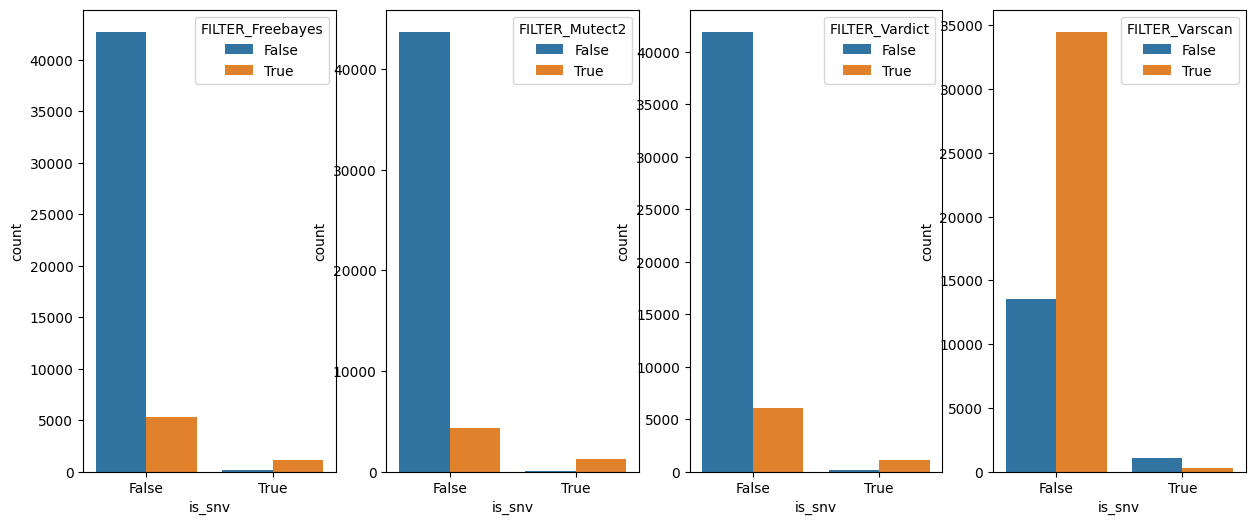

In [132]:
fig, axs = plt.subplots(1, 4, figsize=(15,6))

sns.countplot(df, x="is_snv", stat="count",hue='FILTER_Freebayes', ax=axs[0])
sns.countplot(df, x="is_snv", stat="count",hue='FILTER_Mutect2', ax=axs[1])
sns.countplot(df, x="is_snv", stat="count",hue='FILTER_Vardict', ax=axs[2])
sns.countplot(df, x="is_snv", stat="count",hue='FILTER_Varscan', ax=axs[3])

In [126]:
sns.pairplot(df[list_of_numerical])

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fd33a39c550> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd329a56670> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [130]:
df[list_of_numerical].var().sort_values(ascending=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



END_POS_REF      2.982902e+15
START_POS_REF    2.982902e+15
Unnamed: 0       2.030794e+08
f_QA             8.956769e+07
f_QR             3.767802e+07
vs_DP            1.183095e+06
f_AO             7.189940e+04
m2_MQ0           5.442534e+04
f_RO             3.487964e+04
f_ABP            2.013485e+04
vd_DP            1.485372e+04
f_RPL            1.060094e+04
vd_VD            9.442963e+03
f_ODDS           8.971867e+03
f_RPP            5.316956e+03
m2_NLOD          2.761257e+03
vs_SSC           2.989910e+02
f_MQMR           2.437422e+02
f_MQM            2.234367e+02
m2_FS            1.557046e+02
m2_MQ            4.992708e+01
vd_MSI           2.834330e+01
m2_MQRankSum     4.634673e+00
f_LEN            2.815144e+00
f_AC             6.233222e-01
f_AN             2.008993e-01
f_MEANALT        1.530052e-01
vs_GPV           7.428989e-02
f_PAIRED         6.143798e-02
vd_AF            5.390327e-02
f_AF             5.198387e-02
f_PAIREDR        4.714828e-02
vd_SSF           3.461165e-02
f_AB      

# Feature Selection

# Dummy Section